In [1]:
import laspy
from pyprojroot import here
from copy import deepcopy
import polars as pl
from polars  import col as c
from pdal import Writer, Reader, Pipeline
from plotnine import *
theme_set(theme_bw())
import numpy as np
from numpy.lib.recfunctions import unstructured_to_structured, drop_fields, merge_arrays
from fastcore.basics import snake2camel

In [2]:
las_path = here("data/tree.las")

In [3]:
las_cloud = laspy.read(las_path)

In [4]:
laz_path = las_path.with_suffix(".laz")
las_cloud.write(laz_path)

In [5]:
cloud_np = las_cloud.xyz.copy()

In [6]:
def laspy_to_pdal(las_cloud: laspy.LasData) -> np.ndarray:
    """Convert a laspy.LasData directly to a PDAL-style structured numpy array (no o3dt involved).
    
    - Field names are normalized to CamelCase (PDAL convention).
    - X, Y, Z are taken from las_cloud.x / las_cloud.y / las_cloud.z (float coordinates).
    - Other dimensions are read from las_cloud[dim] where dim comes from las_cloud.point_format.dimension_names.
    """
    cloud_xyz = unstructured_to_structured(las_cloud.xyz, names=['X', 'Y', 'Z'])
    cloud = drop_fields(las_cloud.points.array, ['X', 'Y', 'Z'])
    cloud = merge_arrays([cloud_xyz, cloud], flatten=True)
    # rename fields to CamelCase
    new_names = [snake2camel(name) for name in cloud.dtype.names]
    cloud.dtype.names = new_names
    return cloud


In [7]:
cloud_pdal = laspy_to_pdal(las_cloud)
cloud_pdal

array([(338477.76025, 8073627.82075, 1082.81525, 48124, 17, 0, 2, 0, 0, 0, 722.5313147, 48124, 48124, 48124),
       (338477.76   , 8073627.8295 , 1082.81425, 49741, 17, 0, 2, 0, 0, 0, 660.5856631, 49741, 49741, 49741),
       (338477.769  , 8073627.83125, 1082.81425, 48801, 17, 0, 2, 0, 0, 0, 660.6002612, 48801, 48801, 48801),
       ...,
       (338479.195  , 8073629.058  , 1093.76   , 36350, 17, 0, 5, 0, 0, 0, 281.7533362, 36350, 36350, 36350),
       (338479.195  , 8073629.0645 , 1093.76275, 34405, 17, 0, 5, 0, 0, 0, 281.7599287, 34405, 34405, 34405),
       (338479.13925, 8073629.1605 , 1093.6975 , 17934, 50, 0, 5, 0, 0, 0, 281.8654225, 17934, 17934, 17934)],
      shape=(594056,), dtype=[('X', '<f8'), ('Y', '<f8'), ('Z', '<f8'), ('Intensity', '<u2'), ('BitFields', 'u1'), ('ClassificationFlags', 'u1'), ('Classification', 'u1'), ('UserData', 'u1'), ('ScanAngle', '<i2'), ('PointSourceId', '<u2'), ('GpsTime', '<f8'), ('Red', '<u2'), ('Green', '<u2'), ('Blue', '<u2')])

In [8]:
las_cloud.header.scales

array([0.00025, 0.00025, 0.00025])

In [9]:
las_cloud.header.scales = [0.01, 0.01, 0.01]  # set scale to 1cm

In [10]:
laz_opt_path = las_path.with_name("tree_opt.laz")
las_cloud.write(laz_opt_path)

In [11]:
ply_path = las_path.with_suffix(".ply")
pipe = Writer.ply(ply_path).pipeline(cloud_pdal)
pipe.execute()

594056

In [16]:
ply_opt_path = las_path.with_name("tree_opt.ply")
pipe = Writer.ply(ply_opt_path).pipeline(cloud_pdal[['X', 'Y', 'Z']])
pipe.execute()

594056

In [ ]:
formats = [
    # pretty_name, file_path, 
    []
]

In [ ]:
sizes = pl.DataFrame(
    [
        (p.name, p.stat().st_size / 1024 / 1024)
        for p in [las_path, laz_path, laz_opt_path, ply_path, ply_opt_path]
    ],
    schema=["format", "size"],
)
sizes

/tmp/ipykernel_139999/2570145493.py:1: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.


format,size
str,f64
"""tree.las""",20.443538
"""tree.laz""",7.779264
"""tree_opt.laz""",6.660277
"""tree.ply""",40.659812


In [ ]:
sizes = sizes.with_columns(
    rel_size = c.size / c.size.first()
)
sizes

format,size,rel_size
str,f64,f64
"""tree.las""",20.443538,1.0
"""tree.laz""",7.779264,2.627953
"""tree_opt.laz""",6.660277,3.069472
"""tree.ply""",40.659812,0.502795


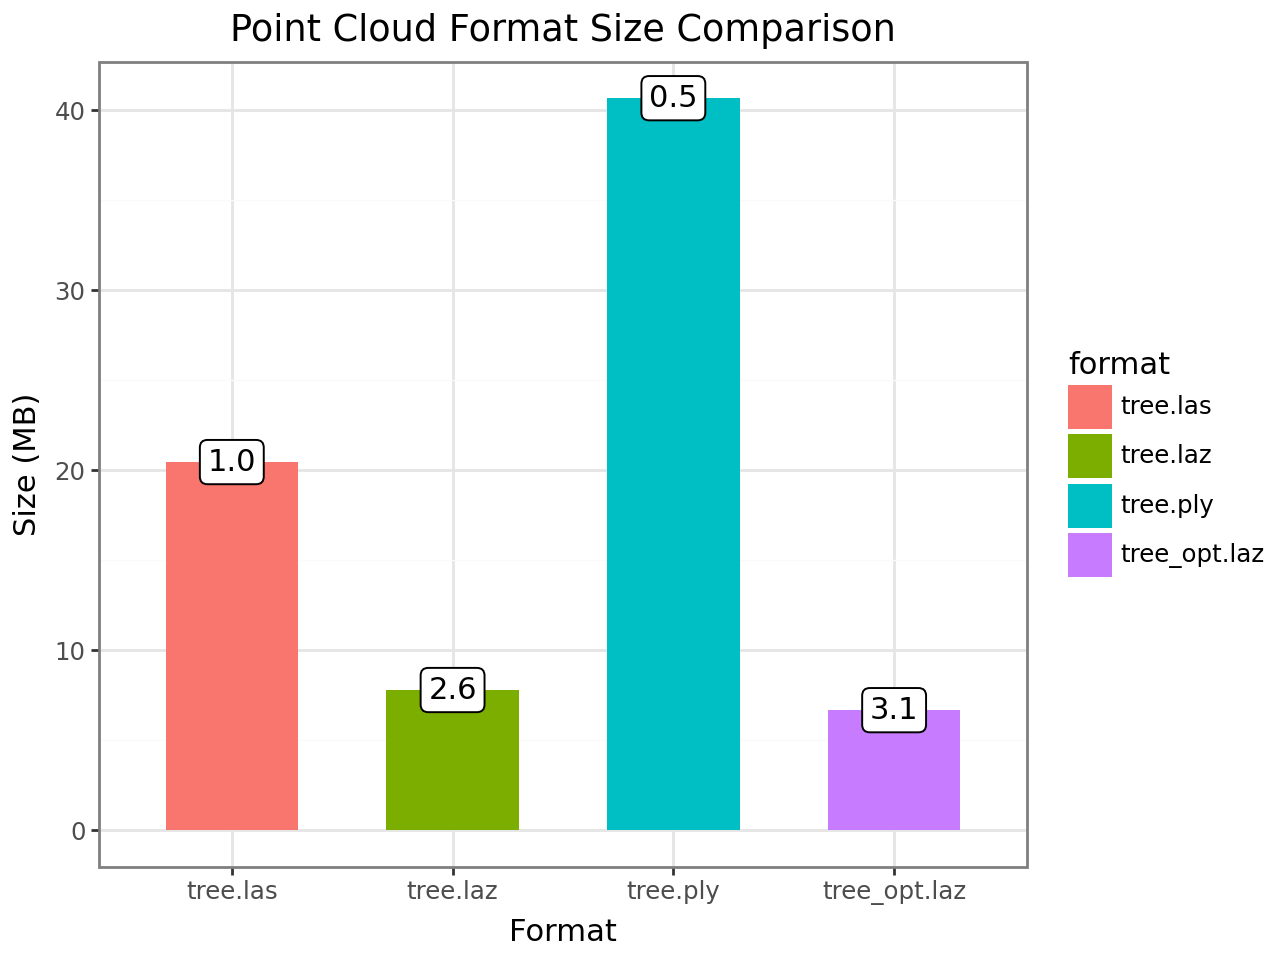

In [14]:
(ggplot(sizes)
 + aes(x="format", y ="size")
 + geom_col(aes(fill="format"), width=0.6)
 + geom_label(aes(label = "rel_size.round(1)"))
    + labs(
        title="Point Cloud Format Size Comparison",
        x="Format",
        y="Size (MB)"
    )
)